## **AI-Based Structural Damage Detection Using Deep Learning (MobileNetV2)**










In [1]:
# import the important librearies

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np



In [ ]:
# 1. SETUP DATA GENERATORS
data_path = '/content/drive/MyDrive/Colab Notebooks/Structural_Damage_Classification/test' # Update this!


datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=90,       # Cracks can be at any angle
    width_shift_range=0.2,   # Move image left/right
    height_shift_range=0.2,  # Move image up/down
    shear_range=0.2,
    zoom_range=0.3,          # Close up vs far away
    horizontal_flip=True,
    vertical_flip=True,      # Important for top-down road photos
    brightness_range=[0.8, 1.2] # Handles shadows/sunlight
)

train_gen = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# 2. BUILD THE MODEL WITH UNFROZEN LAYERS
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Unfreeze the base model
base_model.trainable = True

# Refreeze everything EXCEPT the last 30 layers
# This allows the model to learn specific highway/building textures
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'), # Added more neurons
    layers.BatchNormalization(),          # Stabilizes learning
    layers.Dropout(0.5),                  # Prevents overfitting
    layers.Dense(128, activation='relu'), # Added extra layer
    layers.Dense(1, activation='sigmoid')
])

# Use a Learning Rate Scheduler
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.000001
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Start a bit higher
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train for more epochs to give it time to improve
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    class_weight={0: 3.5, 1: 1.0}, # Keep the weight for Damaged
    callbacks=[lr_schedule]
)




# 6. SAVE THE NEW BRAIN
model.save('finetuned_damage_model.h5')
print("Model Saved!")

Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 140s 9s/step - accuracy: 0.5814 - loss: 1.2576 - val_accuracy: 0.7000 - val_loss: 0.6145 - learning_rate: 1.0000e-04
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.7503 - loss: 0.7419 - val_accuracy: 0.7583 - val_loss: 0.5240 - learning_rate: 1.0000e-04
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.8146 - loss: 0.5361 - val_accuracy: 0.8417 - val_loss: 0.4413 - learning_rate: 1.0000e-04
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.8817 - loss: 0.4647 - val_accuracy: 0.8333 - val_loss: 0.4148 - learning_rate: 1.0000e-04
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9026 - loss: 0.3750 - val_accuracy: 0.8333 - val_loss: 0.4090 - learning_rate: 1.0000e-04
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9035 - loss: 0.3635 - val_accuracy: 0.8750 - val_loss: 0.2915 - learning_rate: 1.0000e-04
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9235 - loss

Model Saved!


In [ ]:
# 6. SAVE THE NEW BRAIN
model.save('finetuned_damage_model.h5')
print("Model Saved!")

Model Saved!


Final Training Accuracy: 95.63%
Final Validation Accuracy: 89.17%


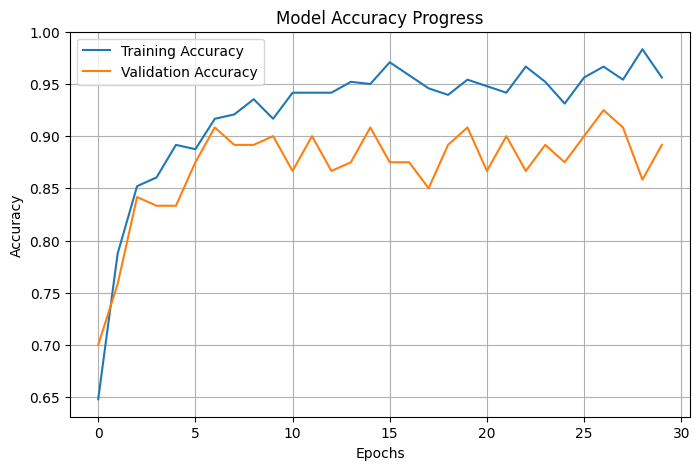

In [ ]:
# Final accuracy from the training history
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%")

# Plot the accuracy curve to show your professor/examiner
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Progress')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Raw AI Score: 0.9816
Verdict: ✅ NON-DAMAGED
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


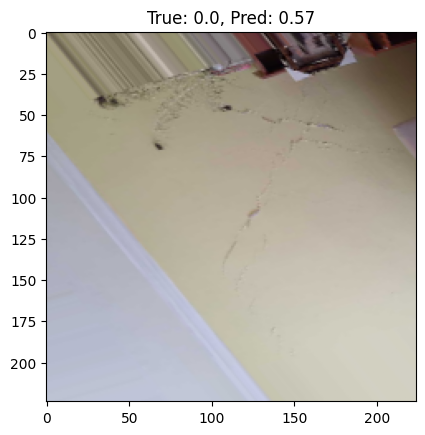

In [ ]:
def test_on_new_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    raw_score = model.predict(x)[0][0]

    print(f"Raw AI Score: {raw_score:.4f}")

    if raw_score < 0.5:
        print("Verdict: ⚠️ DAMAGED")
    else:
        print("Verdict: ✅ NON-DAMAGED")

# Test with an image you know is damaged
test_on_new_image('/content/drive/MyDrive/Colab Notebooks/Structural_Damage_Classification/test/test_Non_Damaged/Non-damaged_highway/5 (757).jpg')


# Code to see which images the model failed on
def show_errors(val_gen, model):
    x, y = next(val_gen)
    preds = model.predict(x)
    for i in range(len(x)):
        if (preds[i] > 0.5) != y[i]:
            plt.imshow((x[i] + 1) / 2)
            plt.title(f"True: {y[i]}, Pred: {preds[i][0]:.2f}")
            plt.show()

show_errors(val_gen, model)

In [ ]:
# This evaluates the model on the data it didn't use for training
results = model.evaluate(val_gen)

print("\n--- Model Performance Report ---")
print(f"Test Loss: {results[0]:.4f}")
print(f"Overall Model Accuracy: {results[1] * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8604 - loss: 0.3165

--- Model Performance Report ---
Test Loss: 0.2984
Overall Model Accuracy: 87.50%


In [ ]:
# 1. Reset the generator and TURN OFF SHUFFLE
val_gen.reset()
val_gen.shuffle = False  # Critical: Keep images and labels in the same order
val_gen.index_array = None

# 2. Re-predict
predictions = model.predict(val_gen)
y_pred = (predictions > 0.5).astype(int)
y_true = val_gen.classes # Now this will match the order of predictions

# 3. Print the REAL report
from sklearn.metrics import classification_report, confusion_matrix
target_names = list(val_gen.class_indices.keys())

print("--- CORRECTED Classification Report ---")
print(classification_report(y_true, y_pred, target_names=target_names))

print("--- CORRECTED Confusion Matrix ---")
print(confusion_matrix(y_true, y_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
--- CORRECTED Classification Report ---
                  precision    recall  f1-score   support

    test_Damaged       0.93      0.83      0.88        60
test_Non_Damaged       0.85      0.93      0.89        60

        accuracy                           0.88       120
       macro avg       0.89      0.88      0.88       120
    weighted avg       0.89      0.88      0.88       120

--- CORRECTED Confusion Matrix ---
[[50 10]
 [ 4 56]]
